In [24]:
%load_ext autoreload
%autoreload 2

,f0,f1,f2,choice
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.498086,0.498086,0.498086,1.072000
std,0.285584,0.285584,0.285584,0.817404
min,0.000037,0.000037,0.000037,0.000000
25%,0.252848,0.252848,0.252848,0.000000
50%,0.499731,0.499731,0.499731,1.000000
75%,0.739599,0.739599,0.739599,2.000000
max,0.999966,0.999966,0.999966,2.000000


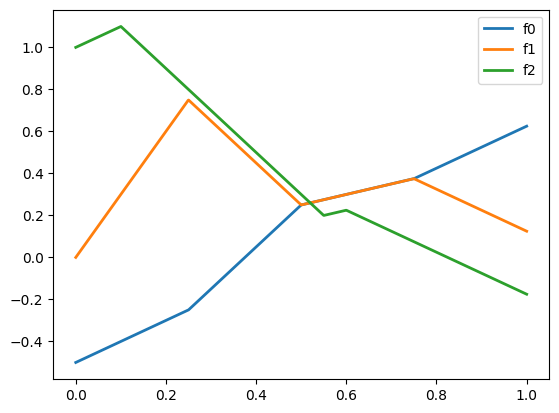

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from rumboost.metrics import cross_entropy
np.random.seed(0)

def compute_levels(sp, betas):
    levels = np.zeros(len(sp))
    for i in range(len(sp) - 1):
        levels[i + 1] = levels[i] + (sp[i + 1] - sp[i]) * betas[i]
    return levels


def create_pw_linear_feature(x, sp, betas, intercept):
    indices = np.searchsorted(sp, x) - 1
    levels = compute_levels(sp, betas) + intercept
    f_x = levels[indices] + betas[indices] * (x - sp[indices])

    return f_x


def apply_linear_feature(x_arr, sp, betas, feature_names, intercept):
    data = pd.DataFrame(
        {
            feature_names[i]: np.array(
                create_pw_linear_feature(x, sp[i], betas[i], intercept[i])
            )
            for i, x in enumerate(x_arr.T)
        }
    )
    return data


def create_dataset(x_arr, feature_names):
    return pd.DataFrame({feature_names[i]: x_arr[:, i] for i in range(x_arr.shape[1])})


def generate_x(n, k, props_low=0.5, cut=0.5, deterministic=False):
    n_low = int(props_low * n)
    n_high = n - n_low
    if deterministic:
        x_low = np.linspace([0]*n_utility, [cut]*n_utility, n_low)
        x_high = np.linspace([cut]*n_utility, [1]*n_utility, n_high)
    else:
        x_low = np.random.uniform(0, cut, (n_low, k))
        x_high = np.random.uniform(cut, 1, (n_high, k))

    return np.concatenate([x_low, x_high], axis=0)


def add_choice(row, u_idx):
    u = np.array([np.sum(row[u_idx[i][0] : u_idx[i][1]]) for i in range(len(u_idx))])
    return np.random.choice(u.shape[0], size=1, p=softmax(u))[0]

n_utility = 3
f_per_utility = 1
x_arr = generate_x(2000, n_utility * f_per_utility, 0.5, 0.5)
x_arr[:, 1] = x_arr[:, 0]
x_arr[:, 2] = x_arr[:, 0]
x_arr_test = generate_x(1000, n_utility * f_per_utility, 0.5, 0.5)
x_arr_test[:, 1] = x_arr_test[:, 0]
x_arr_test[:, 2] = x_arr_test[:, 0]
sp = np.array(
    [
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.34, 0.5, 0.55, 1],
        [0, 0.2, 0.4, 0.8, 1],
        [0, 0.1, 0.55, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
        [0, 0.3, 0.5, 0.7, 1],
        [0, 0.2, 0.4, 0.5, 1],
        [0, 0.25, 0.5, 0.75, 1],
        [0, 0.4, 0.5, 0.6, 1],
    ]
)
betas = np.array(
    [
        [1, 2, 0.5, 1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 0, 0],
        [3, -2, 0.5, -1],
        [0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 1, 1, 0],
        [1, -2, 0.5, -1],
        [-0.5, 0, 0.5, 1],
        [-0.5, -0.5, -2, -3],
        [0, 0, 5, 0],
        [1, 1, 0.9, -1],
        [0.5, -1, 0.5, 1],
        [-0.5, -0.5, 2, -3],
        [0, -1, 0, 0],
    ]
)
intercept = [-0.5, -1.5, 0.5, -1, 0, -2, 1, -2, 1, -1, -0.5, 0.5, -2, 0, 0, 0.5]

ind = [i for i in range(4 * n_utility) if i % 4 < f_per_utility]
sp = [sp[i] for i in ind]
betas = [betas[i] for i in ind]
intercept = [intercept[i] for i in ind]

feature_names = [f"f{i}" for i in range(f_per_utility*n_utility)]

u_idx = [(i * f_per_utility, (i+1) * f_per_utility) for i in range(n_utility)]

x_plot = np.linspace(1e-4, 1, 1000).reshape(-1, 1)
for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
    y_plot = apply_linear_feature(
        x_plot, sp_i.reshape(1, -1), beta_i.reshape(1, -1), feature_names, [inter_i]
    ).values
    plt.plot(x_plot, y_plot, label=feature_names[i], linewidth=2)

plt.legend()

dataset = create_dataset(x_arr, feature_names)
dataset_transf = apply_linear_feature(
    x_arr, sp, betas, feature_names, intercept=intercept
)
dataset["choice"] = dataset_transf.apply(add_choice, axis=1, u_idx=u_idx)
dataset_test = create_dataset(x_arr_test, feature_names)
dataset_test_transf = apply_linear_feature(
    x_arr_test, sp, betas, feature_names, intercept=intercept
)
dataset_test["choice"] = dataset_test_transf.apply(add_choice, axis=1, u_idx=u_idx)

dataset.describe()

## Fake gradient boosting iteration with pandas

In [119]:
import copy
def compute_preds(X):
    preds = softmax(X, axis=1)
    return preds

def compute_grads_and_hess(preds, labels, num_classes=3):
    grads = preds - labels
    factor = num_classes / (num_classes - 1)
    hess = factor * preds * (1 - preds)
    hess = np.maximum(hess, 1e-6)
    return grads, hess

def compute_split_gain(grads, hess, split, feature):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    no_split_gain = np.sum(grads) ** 2 / np.sum(hess)
    left_gain = np.sum(left_grads) ** 2 / np.sum(left_hess)
    right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)

    gain = left_gain + right_gain - no_split_gain
    return gain

def find_best_split(X, grads, hess):
    best_gain = -np.inf
    best_split = None
    best_feature = None
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    for feature in range(X.shape[1]):
        unique_values = np.unique(X[:, feature])
        for split in unique_values:
            gain = compute_split_gain(grads, hess, split, X[:, feature])
            if gain > best_gain:
                best_gain = copy.deepcopy(gain)
                best_split = copy.deepcopy(split)
                best_feature = copy.deepcopy(feature)

    return best_feature, best_split, best_gain

def compute_leaf_value(grads, hess, feature, split):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_value = - np.sum(left_grads) / np.sum(left_hess)
    right_value = - np.sum(right_grads) / np.sum(right_hess)

    return left_value, right_value

def boost(X, y, preds, num_classes=3):
    grads, hess = compute_grads_and_hess(preds, y, num_classes=num_classes)
    feature, split, gain = find_best_split(X, grads, hess)
    left_value, right_value = compute_leaf_value(grads, hess, X[:, feature].reshape(-1), split)

    return feature, split, left_value, right_value, gain

In [120]:
class Tree:
    def __init__(self):
        self.tree = None

    def fit(self, X, y, preds, num_classes=3):
        self.tree = self._build_tree(X, y, preds, num_classes=num_classes)

    def _build_tree(self, X, y, preds, num_classes=3):

        feature, split, left_value, right_value, gain = boost(X, y, preds, num_classes=num_classes)
        if gain <= 0:
            return None

        return {
            "feature": feature,
            "split": split,
            "left_value": left_value,
            "right_value": right_value,
            "gain": gain,
        }

In [121]:
class Ensemble:
    def __init__(self):
        self.trees = []

    def fit(self, X, y, preds, num_classes=3):
        tree = Tree()
        tree.fit(X, y, preds, num_classes=num_classes)
        self.trees.append(tree)

    def predict(self, X):
        preds = np.zeros((X.shape[0]))
        for tree in self.trees:
            if tree.tree is not None:
                feature = tree.tree["feature"]
                split = tree.tree["split"]
                left_value = tree.tree["left_value"]
                right_value = tree.tree["right_value"]

                preds[X[:, feature] <= split] += left_value
                preds[X[:, feature] > split] += right_value

        return preds

In [122]:
class BoostingModel:
    def __init__(self, n_estimators=10, learning_rate=0.1, num_classes=3, feature_indices=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.ensemble = [Ensemble() for _ in range(num_classes)]
        self.feature_indices = feature_indices
        if self.feature_indices is None:
            self.feature_indices = [(i, i+1) for i in range(num_classes)]

    def fit(self, X, y, X_test=None, y_test=None):
        self.initial_preds = np.zeros((1, self.num_classes))
        for j in range(self.num_classes):
            self.initial_preds[:, j] = np.log(np.mean(y==j))
        raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
        preds = softmax(raw_preds, axis=1)
        for i in range(self.n_estimators):
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            for j in range(self.num_classes):
                ensemble = self.ensemble[j]
                ensemble.fit(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]], y == j, preds[:, j], num_classes=self.num_classes)
                raw_preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
            preds = softmax(raw_preds, axis=1)
            print("Train cel:", cross_entropy(preds, y))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                for j in range(self.num_classes):
                    ensemble = self.ensemble[j]
                    test_preds[:, j] += self.learning_rate * ensemble.predict(X_test[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
                test_preds = softmax(test_preds, axis=1)
                print("Test cel:", cross_entropy(test_preds, y_test))

    def predict(self, X):
        preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()

        for j in range(self.num_classes):
            ensemble = self.ensemble[j]
            preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])

        return softmax(preds, axis=1)

In [150]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values

feature_indices = [(i * f_per_utility, (i + 1) * f_per_utility) for i in range(n_utility)]

model = BoostingModel(n_estimators=20, learning_rate=0.1, feature_indices=feature_indices)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain = tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}")

preds = model.predict(X_test)
cel = cross_entropy(preds, y_test)
print(f"Cross-entropy loss: {cel}")

C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_1836\2444038594.py:23: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)


Train cel: 1.0339476820893163
Test cel: 1.0689468256795802
Train cel: 1.0239300511386855
Test cel: 1.0619783762287505
Train cel: 1.0157000908743783
Test cel: 1.0567715580786012
Train cel: 1.00888695640334
Test cel: 1.0523965749178108
Train cel: 1.0032609649007191
Test cel: 1.0492849737800476
Train cel: 0.9985998723835071
Test cel: 1.0466900124127543
Train cel: 0.9945368508643873
Test cel: 1.0443536377410632
Train cel: 0.9909807728403953
Test cel: 1.041887210024656
Train cel: 0.9878660557483017
Test cel: 1.0405010715170013
Train cel: 0.9850385270069061
Test cel: 1.0390555357947866
Train cel: 0.9824925235656351
Test cel: 1.0375745415282498
Train cel: 0.9802268156814984
Test cel: 1.0362750851568432
Train cel: 0.9781526703626742
Test cel: 1.0339397559865064
Train cel: 0.9762726657923441
Test cel: 1.0317621181398575
Train cel: 0.9745907853312501
Test cel: 1.030368605302579
Train cel: 0.9730336570586811
Test cel: 1.0300042306507111
Train cel: 0.971637905788879
Test cel: 1.0290096430075684
Tr

In [136]:
lr = 0.1
md = 1
verbose = 2
mono = False 
# monotonicity_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
# monotonicity_0 = [0, 1, -1, 0] if mono else [0] * 17
monotonicity_0 = [1] if mono else [0] * 17
l1 = 0
l2 = 0
min_data_in_leaf = 1 
min_sum_hessian_in_leaf = 0
min_data_in_bin = 1
mb = 2000
variables_0 = feature_names[:f_per_utility]
dico1 = []
for i, v in enumerate(variables_0):
    dico1.append({
        "utility": [0],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_0[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# monotonicity_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
# monotonicity_1 = [0, 1, -1, 1] if mono else [0]*17
monotonicity_1 = [1] if mono else [0]*17
variables_1 = feature_names[f_per_utility:2*f_per_utility]
dico2 = []
for i, v in enumerate(variables_1):
    dico2.append({
        "utility": [1],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_1[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })
    
# monotonicity_3 = [0 ,0, -1, 1] if mono else [0]*23
monotonicity_3 = [1] if mono else [0]*23
# monotonicity_3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1] if mono else [0]*23
variables_3 = feature_names[2*f_per_utility:3*f_per_utility]
dico3 = []
for i, v in enumerate(variables_3):

    dico3.append({
        "utility": [2],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_3[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

monotonicity_4 = [0, 0, 0, -1] if mono else [0]*20
monotonicity_4 = [1] if mono else [0]*20
variables_4 = feature_names[3*f_per_utility:]
dico4 = []
for i, v in enumerate(variables_4):
    dico4.append({
        "utility": [3],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_4[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# rum_structure = dico1 + dico2 + dico3 #+ dico4
if n_utility == 4:
    rum_structure = dico1 + dico2 + dico3 + dico4
elif n_utility == 3:
    rum_structure = dico1 + dico2 + dico3
else:
    rum_structure = dico1
boost_from_param_space = [False] * len(rum_structure)
# boost_from_param_space = [True] * len(rum_structure)

In [142]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": n_utility,  # important
    "verbosity": 2,  # specific RUMBoost parameter
    "num_iterations": 20,
    # "early_stopping_round": 10,
    # "max_booster_to_update": 23 * 4,
    # "max_booster_to_update": 17 * 4,
    # "max_booster_to_update": 8,
    # "max_booster_to_update": n_utility * f_per_utility,
    # "max_booster_to_update": 1,
    "max_booster_to_update": n_utility,
    # "boost_from_parameter_space": boost_from_param_space + boost_from_param_space2,
    "boost_from_parameter_space": boost_from_param_space, #+ [False]*len(rum_structure2),
    "verbose_interval": 1,
    "optim_interval": 1,
}

In [143]:
torch_tensors = {"device":"cuda"}
# torch_tensors = None

In [144]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [145]:
import pandas as pd
import lightgbm
from rumboost.rumboost import rum_train
# features and label column names
features = [f for f in dataset.columns if f != "choice"]
label = "choice"
# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    dataset, label=dataset[label], free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    dataset_test, label=dataset_test[label], free_raw_data=False
)

In [146]:
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification, valid_sets=[lgb_test_set], torch_tensors=torch_tensors)

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\pwl-experiment\src\rumboost\rumboost.py:2713: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000105 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1
[LightGBM] [Debug] Dataset

In [149]:
for booster in LPMC_model_fully_trained.boosters:
    try:
        print(booster.trees_to_dataframe())
    except:
        continue

    tree_index  node_depth node_index left_child right_child parent_index  \
0            0           1       0-S0       0-L0        0-L1         None   
1            0           2       0-L0       None        None         0-S0   
2            0           2       0-L1       None        None         0-S0   
3            1           1       1-S0       1-L0        1-L1         None   
4            1           2       1-L0       None        None         1-S0   
5            1           2       1-L1       None        None         1-S0   
6            2           1       2-S0       2-L0        2-L1         None   
7            2           2       2-L0       None        None         2-S0   
8            2           2       2-L1       None        None         2-S0   
9            3           1       3-S0       3-L0        3-L1         None   
10           3           2       3-L0       None        None         3-S0   
11           3           2       3-L1       None        None         3-S0   

In [98]:
import lightgbm
train_set = lightgbm.Dataset(
    dataset["f0"].values.reshape(-1, 1), label=dataset[label].values, free_raw_data=False
)
test_set = lightgbm.Dataset(
    dataset_test["f0"].values.reshape(-1, 1), label=dataset_test[label].values, free_raw_data=False
)
params = {
    "learning_rate": 0.1,
    "num_leaves": 32,
    "max_depth": 1,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 0,
    "min_data_in_bin": 1,
    "max_bin": 2000,
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": n_utility,
    "verbosity": 2,
    "eval_metric": "multi_logloss",
    "monotone_constraints": [1],
    "monotone_constraints_method": "advanced",
}

model = lightgbm.train(params, train_set, num_boost_round=20, valid_sets=[test_set])
y_preds_train = model.predict(dataset["f0"].values.reshape(-1, 1))
cel_train = cross_entropy(y_preds_train, dataset[label].values)
print(f"Train cross-entropy loss: {cel_train}")
y_preds = model.predict(dataset_test["f0"].values.reshape(-1, 1))
cel = cross_entropy(y_preds, dataset_test[label].values)
print(f"Cross-entropy loss: {cel}")

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.000055 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 1
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Start training from score -1.262308
[LightGBM] [Info] Start training from score -0.967584
[LightGBM] [Info] Start training from score -1.087672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 2 and depth = 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [99]:
model.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-L0,0-L1,None,Column_0,28.259001,0.480596,<=,left,None,-1.262310,0.000000,1000.0
1,0,2,0-L0,None,None,0-S0,None,NaN,NaN,None,None,None,-1.294601,143.356621,471.0
2,0,2,0-L1,None,None,0-S0,None,NaN,NaN,None,None,None,-1.233557,161.009878,529.0
3,1,1,1-S0,1-L0,1-L1,None,Column_0,2.179800,0.997683,<=,left,None,-0.967584,0.000000,1000.0
4,1,2,1-L0,None,None,1-S0,None,NaN,NaN,None,None,None,-0.967936,352.693192,998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,58,2,58-L0,None,None,58-S0,None,NaN,NaN,None,None,None,-0.005331,191.115747,535.0
154,58,2,58-L1,None,None,58-S0,None,NaN,NaN,None,None,None,0.006420,161.236403,465.0
155,59,1,59-S0,59-L0,59-L1,None,Column_0,0.140207,0.888808,<=,left,None,0.000000,0.000000,1000.0
156,59,2,59-L0,None,None,59-S0,None,NaN,NaN,None,None,None,-0.000884,296.981437,881.0


## Gradient boosting with linear trees

In [3]:
import copy
def compute_preds(X):
    preds = softmax(X, axis=1)
    return preds

def compute_grads_and_hess(preds, labels, num_classes=3):
    grads = preds - labels
    factor = num_classes / (num_classes - 1)
    hess = factor * preds * (1 - preds)
    hess = np.maximum(hess, 1e-6)
    return grads, hess

def compute_split_gain(grads, hess, split, feature):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    no_split_gain = np.sum(grads) ** 2 / np.sum(hess)
    left_gain = np.sum(left_grads) ** 2 / np.sum(left_hess)
    right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)
    bigger_gain_left = left_gain > right_gain

    gain = left_gain + right_gain - no_split_gain
    return gain, bigger_gain_left

def find_best_split(X, grads, hess, linear_trees=False, from_split_point=False):
    best_gain = -np.inf
    best_split = None
    best_feature = None
    best_bigger_gain_left = None
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    for feature in range(X.shape[1]):
        unique_values = np.unique(X[:, feature])
        for split in unique_values:
            if linear_trees and from_split_point:
                grads_ = grads * (X[:, feature] - split)
                hess_ = hess * (X[:, feature] - split)**2
            elif linear_trees:
                grads_ = grads * (X[:, feature])
                hess_ = hess * (X[:, feature])**2
            else:
                grads_ = grads
                hess_ = hess
            gain, bigger_gain_left = compute_split_gain(grads_, hess_, split, X[:, feature])
            if gain > best_gain:
                best_gain = copy.deepcopy(gain)
                best_split = copy.deepcopy(split)
                best_feature = copy.deepcopy(feature)
                best_bigger_gain_left = copy.deepcopy(bigger_gain_left)

    return best_feature, best_split, best_gain, best_bigger_gain_left

def compute_leaf_value(grads, hess, feature, split, bigger_left=False):
    left_mask = feature <= split
    right_mask = feature > split
    left_grads = grads[left_mask]
    right_grads = grads[right_mask]
    left_hess = hess[left_mask]
    right_hess = hess[right_mask]

    left_value = - np.sum(left_grads) / np.sum(left_hess)
    right_value = - np.sum(right_grads) / np.sum(right_hess)
    no_split_value = - np.sum(grads) / np.sum(hess)

    return left_value, right_value, no_split_value

def boost(X, y, preds, num_classes=3, linear_trees=False, from_split_point=False):
    grads, hess = compute_grads_and_hess(preds, y, num_classes=num_classes)
    feature, split, gain, bigger_left = find_best_split(X, grads, hess, linear_trees=linear_trees, from_split_point=from_split_point)
    left_value, right_value, no_split_value = compute_leaf_value(grads, hess, X[:, feature].reshape(-1), split)

    return feature, split, left_value, right_value, gain, no_split_value, bigger_left

In [4]:
class Tree:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.tree = None

    def fit(self, X, y, preds, num_classes=3):
        self.tree = self._build_tree(X, y, preds, num_classes=num_classes)

    def _build_tree(self, X, y, preds, num_classes=3):

        feature, split, left_value, right_value, gain, no_split_value, bigger_left = boost(X, y, preds, num_classes=num_classes, linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        if gain <= 0:
            return None
        
        # if self.from_split_point:
        #     if bigger_left:
        #         left_value = left_value
        #         right_value = 0
        #     else:
        #         left_value = 0
        #         right_value = right_value

        return {
            "feature": feature,
            "split": split,
            "left_value": -left_value if self.linear_trees else left_value,
            "right_value": right_value,
            "gain": gain,
            "left_constant": split * right_value + no_split_value if not self.from_split_point else None,
            "right_constant": split * -left_value + no_split_value if not self.from_split_point else None,
        }

In [5]:
class Ensemble:
    def __init__(self, linear_trees=False, from_split_point=False):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.trees = []

    def fit(self, X, y, preds, num_classes=3):
        tree = Tree(linear_trees=self.linear_trees, from_split_point=self.from_split_point)
        tree.fit(X, y, preds, num_classes=num_classes)
        self.trees.append(tree)

    def predict(self, X):
        preds = np.zeros((X.shape[0]))
        for tree in self.trees:
            if tree.tree is not None:
                split = tree.tree["split"]
                feature = tree.tree["feature"]
                left_value = tree.tree["left_value"]
                right_value = tree.tree["right_value"]
                left_constant = tree.tree["left_constant"]
                right_constant = tree.tree["right_constant"]

                x_f = X[:, feature]

                if self.linear_trees and self.from_split_point:
                    preds[x_f <= split] += left_value * (x_f[x_f <= split] - split)
                    preds[x_f > split] += right_value * (x_f[x_f > split] - split)
                elif self.linear_trees:
                    preds[x_f <= split] += left_value * x_f[x_f <= split] + left_constant
                    # preds[x_f <= split] += left_value * x_f[x_f <= split] 
                    preds[x_f > split] += right_value * x_f[x_f > split] + right_constant 
                    # preds[x_f > split] += right_value * x_f[x_f > split] 
                else:
                    preds[x_f <= split] += left_value
                    preds[x_f > split] += right_value

        return preds

In [6]:
class BoostingModel:
    def __init__(self, n_estimators=10, learning_rate=0.1, num_classes=3, linear_trees=False, from_split_point=False, feature_indices=None):
        self.linear_trees = linear_trees
        self.from_split_point = from_split_point
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.ensemble = [Ensemble(linear_trees=self.linear_trees, from_split_point=self.from_split_point) for _ in range(num_classes)]
        self.feature_indices = feature_indices
        if self.feature_indices is None:
            self.feature_indices = [(i, i+1) for i in range(num_classes)]

    def fit(self, X, y, X_test=None, y_test=None):
        self.initial_preds = np.zeros((1, self.num_classes))
        for j in range(self.num_classes):
            self.initial_preds[:, j] = np.log(np.mean(y==j))
        raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
        preds = softmax(raw_preds, axis=1)
        for i in range(self.n_estimators):
            raw_preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()
            for j in range(self.num_classes):
                ensemble = self.ensemble[j]
                ensemble.fit(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]], y == j, preds[:, j], num_classes=self.num_classes)
                raw_preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
            preds = softmax(raw_preds, axis=1)
            print("Train cel:", cross_entropy(preds, y))

            if X_test is not None and y_test is not None:
                test_preds = np.zeros((X_test.shape[0], self.num_classes)) + self.initial_preds.copy()
                for j in range(self.num_classes):
                    ensemble = self.ensemble[j]
                    test_preds[:, j] += self.learning_rate * ensemble.predict(X_test[:, self.feature_indices[j][0]:self.feature_indices[j][1]])
                test_preds = softmax(test_preds, axis=1)
                print("Test cel:", cross_entropy(test_preds, y_test))

    def predict(self, X, utilities=False):
        preds = np.zeros((X.shape[0], self.num_classes)) + self.initial_preds.copy()

        for j in range(self.num_classes):
            ensemble = self.ensemble[j]
            preds[:, j] += self.learning_rate * ensemble.predict(X[:, self.feature_indices[j][0]:self.feature_indices[j][1]])

        return softmax(preds, axis=1) if not utilities else preds

In [86]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values

model = BoostingModel(n_estimators=100, learning_rate=1, linear_trees=True, from_split_point=False)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain, left_constant, right_constant = tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}")

preds = model.predict(X_test)
cel = cross_entropy(preds, y_test)
print(f"Cross-entropy loss: {cel}")

C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_14240\4003737843.py:23: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)


Train cel: 1.0944114208529538
Test cel: 1.0966886933603686
Train cel: 1.0798992480104943
Test cel: 1.082655767287915
Train cel: 1.074824874135012
Test cel: 1.0791266855262323
Train cel: 1.0690504104189285
Test cel: 1.073746533351145
Train cel: 1.0651095670673523
Test cel: 1.0704309397239666
Train cel: 1.064773190518967
Test cel: 1.0690311216914905
Train cel: 1.0585867200630537
Test cel: 1.0663490458573297
Train cel: 1.0663451576263292
Test cel: 1.0854279302306196
Train cel: 1.050575617130787
Test cel: 1.0579403294418226
Train cel: 1.049555098332025
Test cel: 1.059726449502466
Train cel: 1.0648668628629405
Test cel: 1.0866115532570242
Train cel: 1.0489572894128476
Test cel: 1.0588625052190141
Train cel: 1.4074368352290703
Test cel: 1.4562847966516566
Train cel: 1.1780773899465569
Test cel: 1.1642978410508993
Train cel: 1.0808338500715369
Test cel: 1.0994857795071744
Train cel: 1.070904504661948
Test cel: 1.0858857006092002
Train cel: 1.0753472490416924
Test cel: 1.0789368316293297
Train

KeyboardInterrupt: 

In [88]:
features = [f for f in dataset.columns if f not in ["choice"]]
X, y = dataset[features].values, dataset["choice"].values
X_test, y_test = dataset_test[features].values, dataset_test["choice"].values

model = BoostingModel(n_estimators=100, learning_rate=0.5, linear_trees=True, from_split_point=True)

model.fit(X, y, X_test=X_test, y_test=y_test)
for ensemble in model.ensemble:
    for tree in ensemble.trees:
        feature, split, left_value, right_value, gain, left_constant, right_constant = tree.tree.values()
        print(f"Feature: {feature}, Split: {split}, Gain: {gain}, Left value: {left_value}, Right value: {right_value}")

preds = model.predict(X_test)
cel = cross_entropy(preds, y_test)
print(f"Cross-entropy loss: {cel}")

C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_14240\4003737843.py:22: RuntimeWarning: invalid value encountered in scalar divide
  left_gain = np.sum(left_grads) ** 2 / np.sum(left_hess)
C:\Users\ucesnjs\AppData\Local\Temp\ipykernel_14240\4003737843.py:23: RuntimeWarning: invalid value encountered in scalar divide
  right_gain = np.sum(right_grads) ** 2 / np.sum(right_hess)


Train cel: 1.0873896873208677
Test cel: 1.0889437996480273
Train cel: 1.0817077519019669
Test cel: 1.0837800755955596
Train cel: 1.0770612909352475
Test cel: 1.0796359394637849
Train cel: 1.0730715736688978
Test cel: 1.0761418457512877
Train cel: 1.0693875261108579
Test cel: 1.072963460147981
Train cel: 1.0662602389483231
Test cel: 1.0703048053519792
Train cel: 1.0636710154204811
Test cel: 1.0681358444548337
Train cel: 1.0612898663913313
Test cel: 1.066159257257443
Train cel: 1.0592743568703678
Test cel: 1.0645057806473581
Train cel: 1.0573593949414608
Test cel: 1.0629559223877323
Train cel: 1.0556504253900905
Test cel: 1.0615683052078484
Train cel: 1.054232225704377
Test cel: 1.0604396708106134
Train cel: 1.052961171310368
Test cel: 1.0594159036958177
Train cel: 1.0519024668233323
Test cel: 1.0585869547319233
Train cel: 1.0510126612994461
Test cel: 1.057900298315681
Train cel: 1.0502449579351532
Test cel: 1.057299535172055
Train cel: 1.0495965173821904
Test cel: 1.056813749409016
Trai

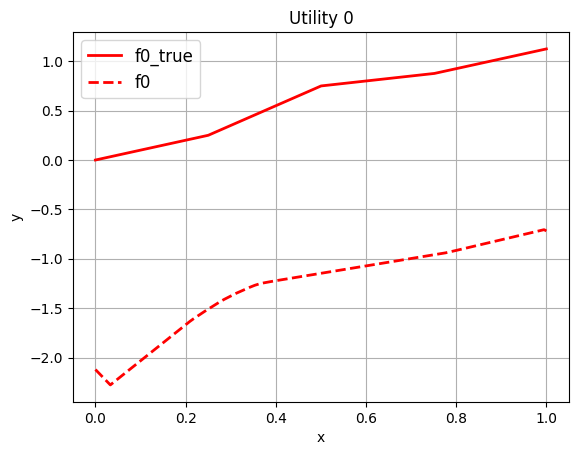

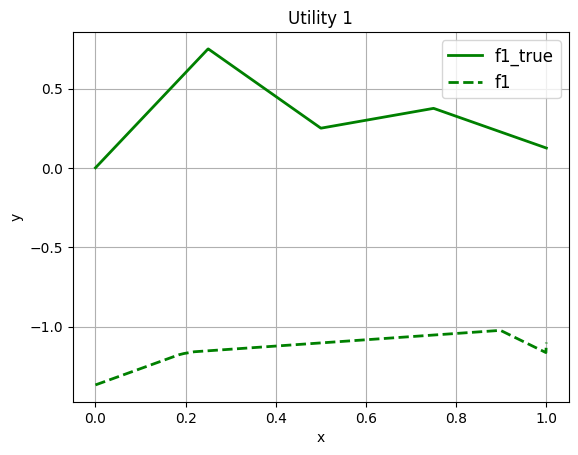

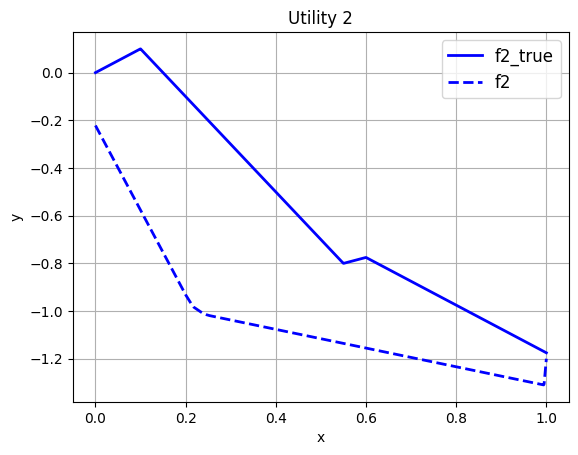

In [89]:
x_plot = np.linspace(1e-4, 1, 1000)

y_plot = []

for i in range(len(feature_names)):
    plot_dataset = pd.DataFrame({feature_names[i]: np.zeros_like(x_plot) for i in range(f_per_utility*n_utility)})
    plot_dataset[feature_names[i]] = x_plot

    if n_utility == 2:
        y_plot.append(model.predict(plot_dataset.values, utilities=True))
    else:
        y_plot.append(model.predict(plot_dataset.values, utilities=True)[:, i // f_per_utility])

colours = ["r", "g", "b", "y", "k", "magenta", "cyan", "orange", "purple", "brown", "pink", "grey", "olive", "lime", "teal", "coral"]


if n_utility == 2:
    
    y_plot_true = []
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true.append(apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values)
    
    y_plot_ttrue = [y_1 - y_0 for y_0, y_1 in zip(y_plot_true[0], y_plot_true[1])]
    y_plot_ttrue = np.array(y_plot_ttrue).reshape(-1)

    plt.plot(x_plot, y_plot_ttrue, label=f"{feature_names[0]}_true", color=colours[0], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
    plt.plot(x_plot, y_plot[0], label=feature_names[0], color=colours[0], linestyle="--", linewidth=2)

    plt.title(f"Utility 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
else:
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        # y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        plt.plot(x_plot, y_plot_true, label=f"{feature_names[i]}_true", color=colours[i], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
        plt.plot(x_plot, y_plot[i], label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)



        if i % f_per_utility == f_per_utility - 1:
            plt.title(f"Utility {i//f_per_utility}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid()
            plt.legend(fontsize=12)
            plt.show()

    # for i in range(len(feature_names)):
    #     plt.figure()
    #     plt.hist(dataset[feature_names[i]], bins=150, alpha=0.5, label=feature_names[i])

In [76]:
lr = 0.1
md = 1
verbose = 2
mono = False 
# monotonicity_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
# monotonicity_0 = [0, 1, -1, 0] if mono else [0] * 17
monotonicity_0 = [1] if mono else [0] * 17
l1 = 0
l2 = 0
min_data_in_leaf = 1 
min_sum_hessian_in_leaf = 0
min_data_in_bin = 1
mb = 2000
variables_0 = feature_names[:f_per_utility]
dico1 = []
for i, v in enumerate(variables_0):
    dico1.append({
        "utility": [0],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_0[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# monotonicity_1 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1] if mono else [0]*17
# monotonicity_1 = [0, 1, -1, 1] if mono else [0]*17
monotonicity_1 = [1] if mono else [0]*17
variables_1 = feature_names[f_per_utility:2*f_per_utility]
dico2 = []
for i, v in enumerate(variables_1):
    dico2.append({
        "utility": [1],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_1[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })
    
# monotonicity_3 = [0 ,0, -1, 1] if mono else [0]*23
monotonicity_3 = [1] if mono else [0]*23
# monotonicity_3 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1] if mono else [0]*23
variables_3 = feature_names[2*f_per_utility:3*f_per_utility]
dico3 = []
for i, v in enumerate(variables_3):

    dico3.append({
        "utility": [2],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_3[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

monotonicity_4 = [0, 0, 0, -1] if mono else [0]*20
monotonicity_4 = [1] if mono else [0]*20
variables_4 = feature_names[3*f_per_utility:]
dico4 = []
for i, v in enumerate(variables_4):
    dico4.append({
        "utility": [3],
        "variables": [v],
        "boosting_params": {
            'boosting': 'gbdt',
            'monotone_constraints_method': 'advanced',
            "max_depth": md,
            "n_jobs": -1,
            "learning_rate": lr,
            "verbose": verbose,
            "monotone_constraints": [monotonicity_4[i]],
            "lambda_l2": l2,
            "lambda_l1": l1,
            "min_data_in_leaf": min_data_in_leaf,
            "min_sum_hessian_in_leaf": min_sum_hessian_in_leaf,
            "max_bin": mb,
            "min_data_in_bin": min_data_in_bin,
        },
        "shared": False,
    })

# rum_structure = dico1 + dico2 + dico3 #+ dico4
if n_utility == 4:
    rum_structure = dico1 + dico2 + dico3 + dico4
elif n_utility == 3:
    rum_structure = dico1 + dico2 + dico3
else:
    rum_structure = dico1
# boost_from_param_space = [False] * len(rum_structure)
boost_from_param_space = [True] * len(rum_structure)

In [77]:
# parameters
general_params = {
    "n_jobs": -1,
    "num_classes": n_utility,  # important
    "verbosity": 2,  # specific RUMBoost parameter
    "num_iterations": 10,
    # "early_stopping_round": 10,
    # "max_booster_to_update": 23 * 4,
    # "max_booster_to_update": 17 * 4,
    # "max_booster_to_update": 8,
    # "max_booster_to_update": n_utility * f_per_utility,
    # "max_booster_to_update": 1,
    "max_booster_to_update": n_utility,
    # "boost_from_parameter_space": boost_from_param_space + boost_from_param_space2,
    "boost_from_parameter_space": boost_from_param_space, #+ [False]*len(rum_structure2),
    "verbose_interval": 1,
    "optim_interval": 1,
}

In [78]:
torch_tensors = {"device":"cuda"}
# torch_tensors = None

In [79]:
model_specification = {
    "general_params": general_params,
    "rum_structure": rum_structure,
}

In [80]:
import pandas as pd
import lightgbm
from rumboost.rumboost import rum_train
# features and label column names
features = [f for f in dataset.columns if f != "choice"]
label = "choice"
# create lightgbm dataset
lgb_train_set = lightgbm.Dataset(
    dataset, label=dataset[label], free_raw_data=False
)
lgb_test_set = lightgbm.Dataset(
    dataset_test, label=dataset_test[label], free_raw_data=False
)

In [85]:
LPMC_model_fully_trained = rum_train(lgb_train_set, model_specification, valid_sets=[lgb_test_set], torch_tensors=torch_tensors)

Using torch tensors on cuda
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Warning] Unknown parameter: boost_from_parameter_space
[LightGBM] [Warning] Unknown parameter: max_booster_to_update
[LightGBM] [Warning] Unknown parameter: verbose_interval
[LightGBM] [Warning] Unknown parameter: optim_interval
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000001 seconds, init for row-wise cost 0.000064 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\pwl-experiment\src\rumboost\rumboost.py:2717: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

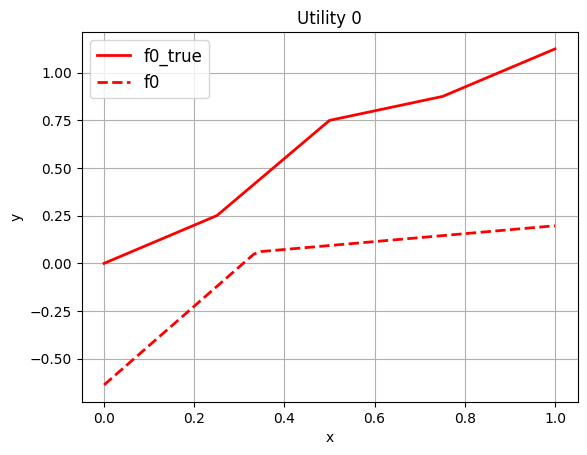

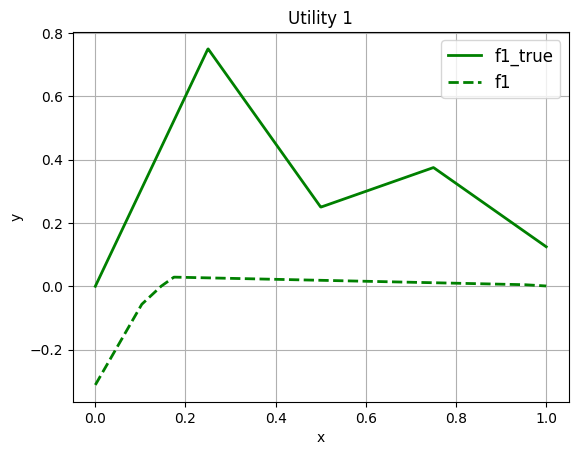

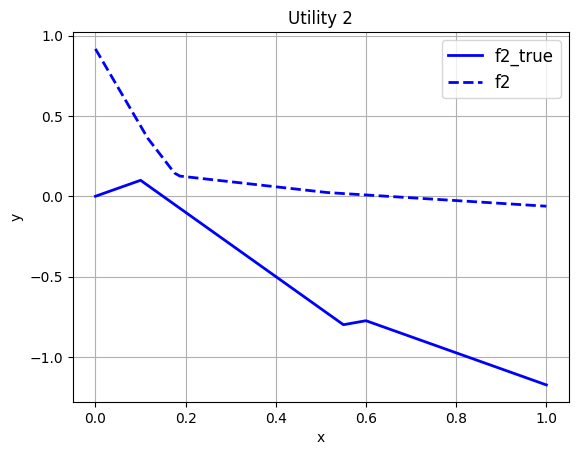

In [82]:
x_plot = np.linspace(1e-4, 1, 1000)

y_plot = []

for i in range(len(feature_names)):
    plot_dataset = pd.DataFrame({feature_names[i]: np.zeros_like(x_plot) for i in range(f_per_utility*n_utility)})
    plot_dataset[feature_names[i]] = x_plot
    plot_dataset_lgb = lightgbm.Dataset(plot_dataset, free_raw_data=False)

    if n_utility == 2:
        y_plot.append(LPMC_model_fully_trained.predict(plot_dataset_lgb, utilities=True))
    else:
        y_plot.append(LPMC_model_fully_trained.predict(plot_dataset_lgb, utilities=True)[:, i // f_per_utility])
    if LPMC_model_fully_trained.device is not None:
        y_plot[-1] = y_plot[-1].cpu().numpy()

colours = ["r", "g", "b", "y", "k", "magenta", "cyan", "orange", "purple", "brown", "pink", "grey", "olive", "lime", "teal", "coral"]


if n_utility == 2:
    
    y_plot_true = []
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true.append(apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values)
    
    y_plot_ttrue = [y_1 - y_0 for y_0, y_1 in zip(y_plot_true[0], y_plot_true[1])]
    y_plot_ttrue = np.array(y_plot_ttrue).reshape(-1)

    plt.plot(x_plot, y_plot_ttrue, label=f"{feature_names[0]}_true", color=colours[0], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
    plt.plot(x_plot, y_plot[0], label=feature_names[0], color=colours[0], linestyle="--", linewidth=2)

    plt.title(f"Utility 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()
else:
    for i, (sp_i, beta_i, inter_i) in enumerate(zip(sp, betas, intercept)):
        if i % f_per_utility == 0:
            plt.figure()
        y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [0]).values
        # y_plot_true = apply_linear_feature(x_plot.reshape(-1,1), sp_i.reshape(1,-1), beta_i.reshape(1,-1), feature_names[i], [inter_i]).values
        plt.plot(x_plot, y_plot_true, label=f"{feature_names[i]}_true", color=colours[i], linewidth=2)
        # ascc = ascs[i//f_per_utility].cpu().numpy() if LPMC_model_fully_trained.device is not None else ascs[i//f_per_utility]
        # plt.plot(x_plot, y_plot[i]+ascc, label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)
        plt.plot(x_plot, y_plot[i], label=feature_names[i], color=colours[i], linestyle="--", linewidth=2)



        if i % f_per_utility == f_per_utility - 1:
            plt.title(f"Utility {i//f_per_utility}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.grid()
            plt.legend(fontsize=12)
            plt.show()

    # for i in range(len(feature_names)):
    #     plt.figure()
    #     plt.hist(dataset[feature_names[i]], bins=150, alpha=0.5, label=feature_names[i])

In [ ]:
for booster in LPMC_model_fully_trained.boosters:
    try:
        print(booster.trees_to_dataframe())
    except:
        continue

    tree_index  node_depth node_index left_child right_child parent_index  \
0            0           1       0-S0       0-L0        0-L1         None   
1            0           2       0-L0       None        None         0-S0   
2            0           2       0-L1       None        None         0-S0   
3            1           1       1-S0       1-L0        1-L1         None   
4            1           2       1-L0       None        None         1-S0   
5            1           2       1-L1       None        None         1-S0   
6            2           1       2-S0       2-L0        2-L1         None   
7            2           2       2-L0       None        None         2-S0   
8            2           2       2-L1       None        None         2-S0   
9            3           1       3-S0       3-L0        3-L1         None   
10           3           2       3-L0       None        None         3-S0   
11           3           2       3-L1       None        None         3-S0   

In [276]:
dataset[features[0]].values.max()

np.float64(0.9999655735094081)

In [313]:

from interpret.glassbox import APLRClassifier, ExplainableBoostingClassifier
from lightgbm import train
model_aplr = APLRClassifier(random_state=42, m=10, max_interaction_level=0, verbosity=1, min_observations_in_split=1, v = 1, bins=2000)
# model_aplr = ExplainableBoostingClassifier(random_state=42)
model_aplr.fit(dataset[features[0]].values, dataset[label], X_names=[features[0]])

Model terms: 10. Terms available in final boosting step: 1.
Model terms: 8. Terms available in final boosting step: 1.
Model terms: 8. Terms available in final boosting step: 1.
Model terms: 9. Terms available in final boosting step: 1.
Model terms: 10. Terms available in final boosting step: 1.
Model terms: 6. Terms available in final boosting step: 1.
Model terms: 6. Terms available in final boosting step: 1.
Model terms: 6. Terms available in final boosting step: 1.
Model terms: 6. Terms available in final boosting step: 1.
Model terms: 6. Terms available in final boosting step: 1.
Model terms: 7. Terms available in final boosting step: 1.
Model terms: 7. Terms available in final boosting step: 1.
Model terms: 7. Terms available in final boosting step: 1.
Model terms: 7. Terms available in final boosting step: 1.
Model terms: 6. Terms available in final boosting step: 1.


In [314]:
from rumboost.metrics import cross_entropy
# preds = model_aplr.predict_class_probabilities(dataset_test[features[0]].values)
preds = model_aplr.predict_proba(dataset_test[features[0]].values)
print(cross_entropy(preds, dataset_test[label].astype(int).values))

1.0587444243731121


In [290]:

from interpret import show
show(model_aplr.explain_global())

<!-- http://127.0.0.1:7001/2008072439632/ -->